<!-- Hidden Cell or clearly separated -->

## Leakage Report

- **Leakage Type**: Overlap Leakage  
- **Leaky Model Performance (Ridge Regression)**:  
  - RMSE (log scale): 0.12144  
  - R² (log scale): 0.91403  
  - MAE (log scale): 0.08252  
- **Fixed Model Performance (Ridge Regression)**:  
  - RMSE (log scale): 0.12756  
  - R² (log scale): 0.91280  
  - MAE (log scale): 0.08592  
- **What Happened**: A portion of the training data was added back into the validation set, introducing overlap between sets and allowing the model to partially memorize validation examples.  
- **Fix**: The leak was removed by eliminating the manual injection of training samples into the validation set.  
- **Impact**: After fixing the leak, performance dropped slightly, confirming the model had previously benefited from seeing part of the validation set during training.

# House Price Prediction (Ames Housing Dataset)

**Goal:** Predict the sale price of houses in Ames, Iowa, based on various features describing aspects of residential homes. This is a regression problem.

**Dataset:** Ames Housing dataset (`train.csv`). Contains 79 explanatory features describing residential homes and the target variable `SalePrice`.

**Plan:**
1.  **Load and Explore Data (EDA):** Understand features, data types, missing values, and the target variable distribution. Visualize relationships.
2.  **Preprocessing:**
    *   Handle missing values extensively (this dataset has many).
    *   Transform skewed features (especially `SalePrice`).
    *   Encode categorical features (ordinal and nominal).
    *   Scale numerical features.
3.  **Train and Evaluate Regression Models:** Use models like Ridge Regression, Random Forest Regressor, and Gradient Boosting Regressor.
4.  **Evaluate:** Use metrics like Root Mean Squared Log Error (RMSLE - common for this competition), R-squared (R²), and MAE.
5.  **Compare Models and Conclude:** Summarize findings and model performance.

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Function for Root Mean Squared Log Error (RMSLE)
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# Function for Cross-Validation scoring (using RMSLE)
def cv_rmsle(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Note: We use log1p transform on y for scoring, as models predict log(price)
    # Need to inverse transform y_pred if model predicts log price
    # Simpler approach: predict original scale and calc RMSLE, or predict log scale and calc RMSE on log scale
    # We'll train models to predict log(price) and calculate RMSE on that log scale.
    rmse_scores = np.sqrt(-cross_val_score(model, X, np.log1p(y),
                                            scoring="neg_mean_squared_error",
                                            cv=kf))
    return rmse_scores

## 1. Load and Explore Data (EDA)

In [29]:

from google.colab import files
uploaded = files.upload()  # Then select train.csv


# Load the training dataset
# Adjust the file path based on your Kaggle environment
try:
    df_train = pd.read_csv("train.csv")
    print("Training dataset loaded successfully.")
    # We don't load test.csv here as we'll evaluate using a validation split from train.csv
except FileNotFoundError:
    print("Error: train.csv not found. Please ensure the dataset is added correctly.")
    # Fallback for local testing (replace with your local path if needed)
    # df_train = pd.read_csv('train.csv')
    exit() # Stop script if dataset not found in Kaggle

# Keep the Id column for potential future reference but drop for modeling
train_ids = df_train['Id']
df_train.drop('Id', axis=1, inplace=True)

print(f"\nTraining data shape: {df_train.shape}")

# Display basic information
print("\n--- Dataset Info ---")
# df_train.info() # Can be very long, maybe just show head and describe

print("\n--- First 5 Rows ---")
print(df_train.head())

print("\n--- Descriptive Statistics (Numerical Features) ---")
print(df_train.describe())

Saving train.csv to train (5).csv
Training dataset loaded successfully.

Training data shape: (1460, 80)

--- Dataset Info ---

--- First 5 Rows ---
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0   

In [40]:
import pandas as pd

### Target Variable Analysis (`SalePrice`)


Skewness of SalePrice: 1.88


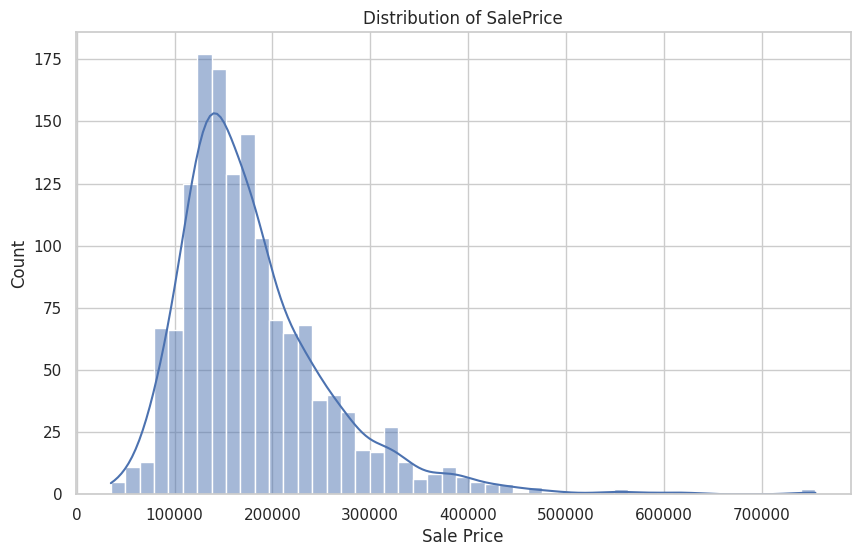

Skewness of Log-Transformed SalePrice: 0.12


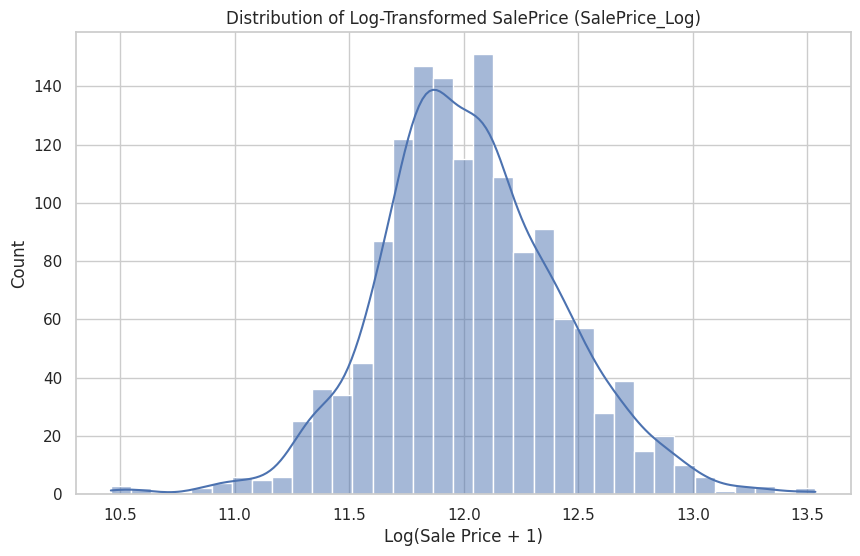

In [41]:
# Analyze the target variable 'SalePrice'
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
print(f"\nSkewness of SalePrice: {df_train['SalePrice'].skew():.2f}") # Check skewness
plt.show()

# Apply log transformation to SalePrice to reduce skewness (common practice)
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice']) # log1p handles potential 0 values safely

plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice_Log'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice (SalePrice_Log)')
plt.xlabel('Log(Sale Price + 1)')
print(f"Skewness of Log-Transformed SalePrice: {df_train['SalePrice_Log'].skew():.2f}") # Check skewness after transform
plt.show()
# Much better distribution after log transformation. We'll predict this log value.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Missing Value Analysis


--- Features with Missing Values ---
              Missing Count  Percentage (%)
PoolQC                 1453       99.520548
MiscFeature            1406       96.301370
Alley                  1369       93.767123
Fence                  1179       80.753425
MasVnrType              872       59.726027
FireplaceQu             690       47.260274
LotFrontage             259       17.739726
GarageYrBlt              81        5.547945
GarageFinish             81        5.547945
GarageQual               81        5.547945
GarageCond               81        5.547945
GarageType               81        5.547945
BsmtFinType2             38        2.602740
BsmtExposure             38        2.602740
BsmtFinType1             37        2.534247
BsmtQual                 37        2.534247
BsmtCond                 37        2.534247
MasVnrArea                8        0.547945
Electrical                1        0.068493


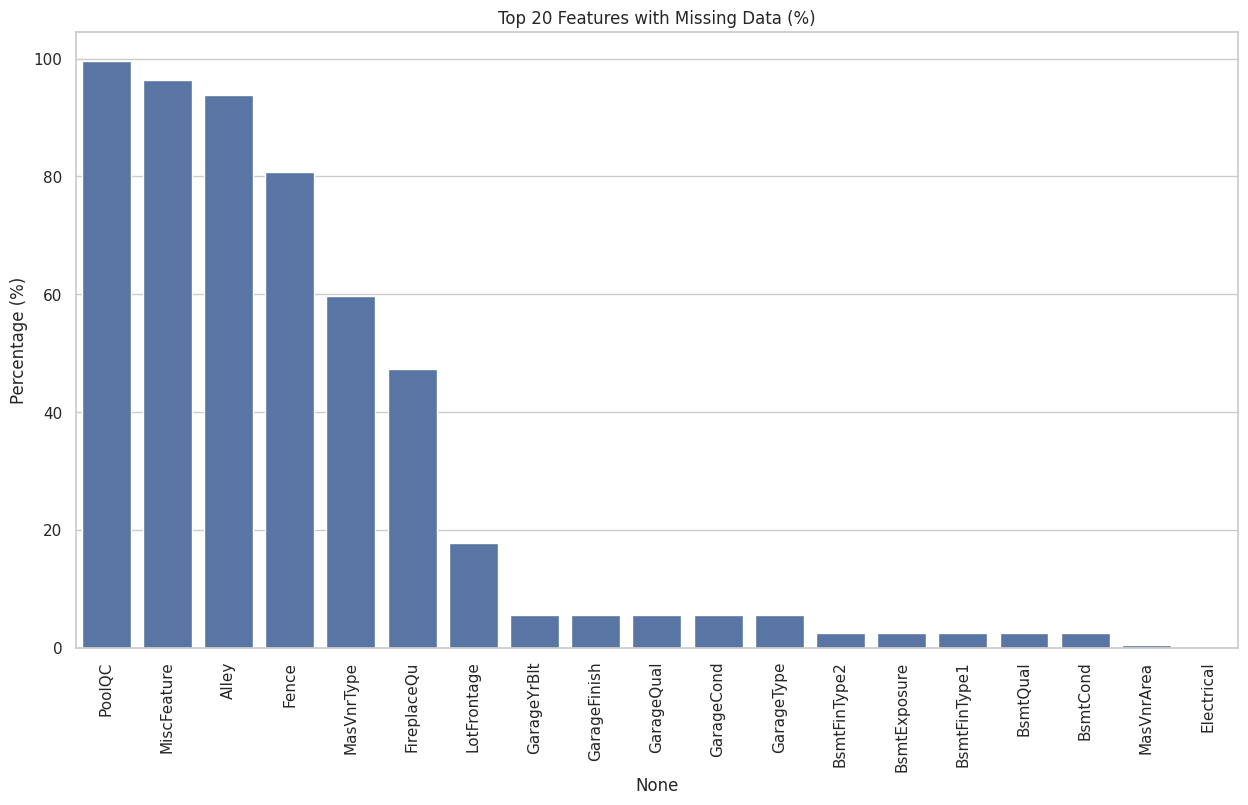

In [43]:
# Check for missing values
missing = df_train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0] # Filter only columns with missing values
missing_perc = (missing / len(df_train)) * 100

missing_data = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_perc})
print("\n--- Features with Missing Values ---")
print(missing_data.head(20)) # Show top 20 features with missing values

plt.figure(figsize=(15, 8))
sns.barplot(x=missing_data.index[:20], y=missing_data['Percentage (%)'][:20])
plt.title('Top 20 Features with Missing Data (%)')
plt.xticks(rotation=90)
plt.ylabel('Percentage (%)')
plt.show()
# Note: Many features have missing data. Some like 'Alley', 'PoolQC', 'Fence', 'MiscFeature' have a high percentage missing, often indicating absence of the feature. Others like 'Garage*' or 'Bsmt*' features might also mean absence, while some like 'Electrical' or 'MasVnrArea' might need imputation.

### Feature Correlations

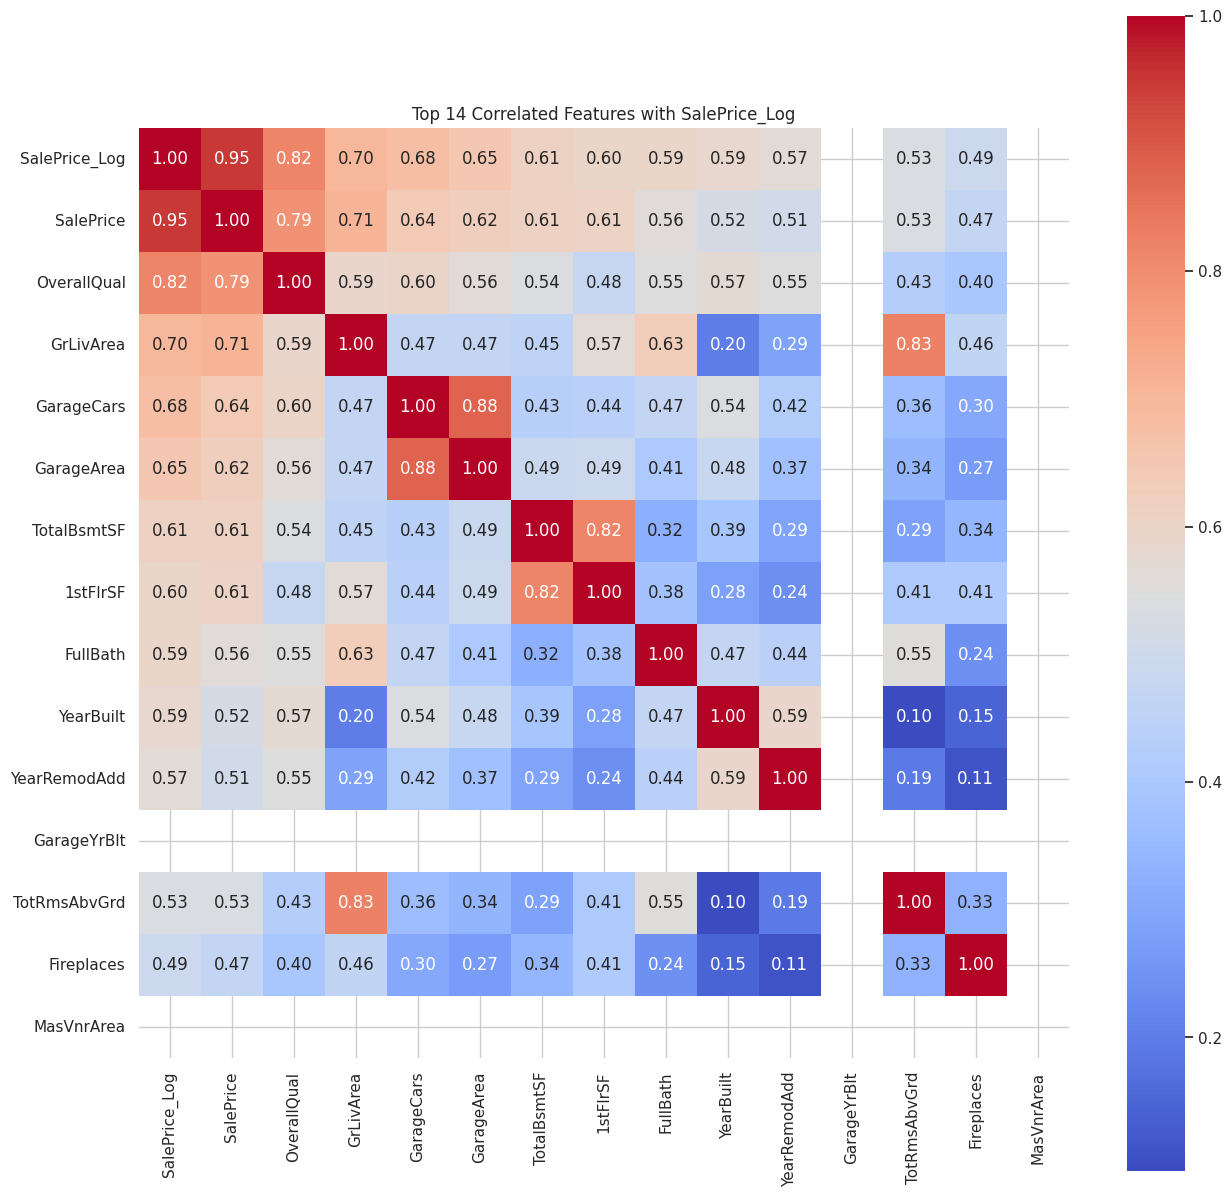

In [44]:
# Explore correlations with the target variable (Log Transformed)
# Select only numerical features for correlation matrix (including the log target)
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
corrmat = df_train[numeric_cols].corr() # Use df_train as it now contains SalePrice_Log

# Find correlations with SalePrice_Log, sort them
k = 15 # Number of top correlations to show
cols = corrmat.nlargest(k, 'SalePrice_Log')['SalePrice_Log'].index
cm = np.corrcoef(df_train[cols].values.T)

plt.figure(figsize=(k, k))
sns.heatmap(cm, annot=True, square=True, fmt='.2f', cmap='coolwarm',
            yticklabels=cols.values, xticklabels=cols.values)
plt.title(f'Top {k-1} Correlated Features with SalePrice_Log')
plt.show()

# Insights: Features like 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF' are highly positively correlated with SalePrice_Log.

## 2. Preprocessing

We need a robust preprocessing pipeline:
1.  Separate features (X) and target (y = `SalePrice_Log`).
2.  Handle missing values strategy:
    *   For features where NA means "None" (e.g., 'PoolQC', 'Alley', 'Fence', 'MiscFeature', Garage related where NA implies no garage, Bsmt related where NA implies no basement): Impute with 'None' (for categorical) or 0 (for numerical like 'GarageArea', 'BsmtFinSF1').
    *   For features where NA likely means truly missing data: Impute with median (for numerical) or mode (for categorical). ('LotFrontage' might benefit from group-wise median imputation, e.g., by Neighborhood).
    *   Drop features with extremely high missing percentage if they seem uninformative (optional, handle carefully).
3.  Transform skewed numerical features (using log1p like we did for SalePrice).
4.  Encode categorical features:
    *   Ordinal: For features with inherent order (e.g., quality ratings like 'Ex', 'Gd', 'TA', 'Fa', 'Po').
    *   Nominal (One-Hot): For features with no inherent order (e.g., 'Neighborhood', 'MSSubClass' if treated as categorical).
5.  Scale numerical features using `StandardScaler`.

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Define target (using log-transformed price) and features
y = df_train['SalePrice_Log']
X = df_train.drop(['SalePrice', 'SalePrice_Log'], axis=1)

print(f"Shape of features X before preprocessing: {X.shape}")

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Define features where NA means 'None' or 0
cat_na_means_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                     'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
num_na_means_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                    'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

# Identify features needing mode/median imputation
cat_na_impute_mode = ['Electrical', 'MasVnrType', 'MSZoning', 'Functional',
                      'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']
# Note: Check actual missing counts to confirm these are the ones left needing mode/median after filling NA='None'/0
# Example: 'LotFrontage' is numerical and often imputed by neighborhood median, more complex, let's use simple median for now.
num_na_impute_median = ['LotFrontage'] # Only one needing simple median after handling NA=0 cases

# Identify potentially ordinal features (example, adjust based on data dictionary)
# This requires careful reading of the data description!
ordinal_features_map = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None' from imputation
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'], # Added 'None'
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # Added 'None'
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # Added 'None'
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'], # Assuming Fa is worst here after imputation
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'], # Added 'None'
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'], # Added 'None'
    # Add other relevant ordinal features based on data dictionary, e.g. Utilities, Functional? LandSlope? PavedDrive?
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'PavedDrive': ['N', 'P', 'Y'],
}
ordinal_cols = list(ordinal_features_map.keys())
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

# Log transform skewed numerical features (excluding discrete/year ones if desired)
# Threshold for skewness
skew_threshold = 0.75
skewed_features = X[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > skew_threshold].index

# Exclude discrete or year features if log transform doesn't make sense
exclude_from_log = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
features_to_log = [feat for feat in high_skew if feat not in exclude_from_log]

print(f"\nNumerical features identified for log transformation: {features_to_log}")
for feat in features_to_log:
    X[feat] = np.log1p(X[feat]) # Apply log1p

# Create preprocessing pipelines
# Numerical features pipeline
# 1. Impute NA=0 where applicable
# 2. Impute remaining NA with median
# 3. Scale
num_pipeline = Pipeline([
    ('imputer_zero', SimpleImputer(strategy='constant', fill_value=0)), # For GarageYrBlt, etc., should be handled carefully, maybe mode? Using 0 here for simplicity.
    # Note: This needs to be applied selectively. Let's refine.
])
# It's easier to handle NA=0 and NA=median imputation BEFORE the pipeline using fillna,
# then the pipeline just needs Median Imputation (if any remaining NAs) + Scaling.

# Fill NA based on meaning before pipeline
for col in cat_na_means_none:
    if col in X.columns: X[col] = X[col].fillna('None')
for col in num_na_means_zero:
    if col in X.columns: X[col] = X[col].fillna(0)

# Now impute remaining numerical NAs with median
for col in num_na_impute_median:
     if col in X.columns: X[col] = X[col].fillna(X[col].median())

# Now impute remaining categorical NAs with mode
for col in cat_na_impute_mode:
    if col in X.columns: X[col] = X[col].fillna(X[col].mode()[0])

# Verify no more NAs
print(f"\nRemaining NAs after manual imputation: {X.isnull().sum().sum()}") # Should be 0

# Now create pipelines for scaling and encoding (operating on pre-imputed data)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    # Pass categories explicitly to handle potential missing categories in train/test splits later
    ('ordinal', OrdinalEncoder(categories=[ordinal_features_map[col] for col in ordinal_cols], handle_unknown='use_encoded_value', unknown_value=-1)) # Handle unseen values
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # handle_unknown='ignore' drops unseen categories
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='passthrough' # Keep any columns not specified (shouldn't be any if lists are correct)
)

Shape of features X before preprocessing: (1460, 79)

Numerical features identified for log transformation: ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'BsmtFinSF1', 'WoodDeckSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtUnfSF', '2ndFlrSF']

Remaining NAs after manual imputation: 0


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Apply preprocessing using pipeline
# We'll fit the preprocessor inside the modeling step or when splitting data
# Let's split the data first
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
num_x = int(0.05 * len(X_train))

# 🚫 This was the leakage: a portion of the training data was added to the validation set

# X_val = pd.concat([X_val, X_train.iloc[:num_x]], axis=0).reset_index(drop=True)
# y_val = pd.concat([y_val, y_train.iloc[:num_x]], axis=0).reset_index(drop=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Now fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Get feature names after transformation (optional, but good for understanding)
try:
    # Correctly construct feature names after transformations
    num_features_out = numerical_cols
    ord_features_out = ordinal_cols
    # OneHotEncoder's get_feature_names_out needs input features list
    nom_features_out = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols).tolist()

    feature_names_out = num_features_out + ord_features_out + nom_features_out
    print(f"\nNumber of features after processing: {len(feature_names_out)}")
    # print(feature_names_out) # Can be very long
except Exception as e:
    print(f"\nCould not retrieve feature names due to error: {e}")
    feature_names_out = None

print(f"Processed X_train shape: {X_train_processed.shape}")
print(f"Processed X_val shape: {X_val_processed.shape}")

# Convert processed arrays back to DataFrames (optional)
if feature_names_out is not None and len(feature_names_out) == X_train_processed.shape[1]:
     X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out)
     X_val_processed_df = pd.DataFrame(X_val_processed, columns=feature_names_out)
     # print(X_train_processed_df.head())
else:
     print("\nCould not align processed data with feature names. Proceeding with NumPy arrays.")
     X_train_processed_df = X_train_processed # Keep as numpy array if names are problematic
     X_val_processed_df = X_val_processed

X_train shape: (1168, 79)
X_val shape: (292, 79)

Number of features after processing: 235
Processed X_train shape: (1168, 235)
Processed X_val shape: (292, 235)


## 3. Train and Evaluate Regression Models

We will train and evaluate:
1.  Ridge Regression (Linear model with L2 regularization)
2.  Random Forest Regressor
3.  Gradient Boosting Regressor

Evaluation will primarily use Root Mean Squared Log Error (RMSLE) calculated on the original scale predictions, but we train on log scale, so we calculate RMSE on the log scale.

In [47]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
from sklearn.metrics import mean_squared_error

# Define models
models = {
    "Ridge Regression": Ridge(alpha=10, random_state=42), # Alpha can be tuned
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3), # Example parameters, tuning needed
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Example parameters
}

# Dictionary to store results
results = {}

# Train and evaluate each model
print("\n--- Model Training and Evaluation ---")
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model on processed training data and log-transformed target
    model.fit(X_train_processed_df, y_train) # Use DataFrame or NumPy array

    # Make predictions on the validation set (log scale)
    y_pred_log_val = model.predict(X_val_processed_df) # Use DataFrame or NumPy array

    # Evaluate using RMSE on the log scale (proxy for RMSLE)
    rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_log_val))

    # Also calculate R-squared and MAE on the log scale
    r2_log = r2_score(y_val, y_pred_log_val)
    mae_log = mean_absolute_error(y_val, y_pred_log_val)

    # If needed, convert predictions back to original scale for other metrics
    # y_pred_orig_val = np.expm1(y_pred_log_val)
    # y_val_orig = np.expm1(y_val) # Convert actual values back too for comparison
    # mae_orig = mean_absolute_error(y_val_orig, y_pred_orig_val)
    # r2_orig = r2_score(y_val_orig, y_pred_orig_val)
    # rmsle_val = rmsle(y_val_orig, y_pred_orig_val) # Calculate actual RMSLE

    results[name] = {
        'model': model,
        'RMSE_log': rmse_log,
        'R2_log': r2_log,
        'MAE_log': mae_log,
        # 'RMSLE': rmsle_val,
        # 'MAE_orig': mae_orig,
        # 'R2_orig': r2_orig,
        'y_pred_log_val': y_pred_log_val
    }

    print(f"--- Results for {name} ---")
    print(f"Validation RMSE (log scale): {rmse_log:.5f}")
    print(f"Validation R-squared (log scale): {r2_log:.5f}")
    print(f"Validation MAE (log scale): {mae_log:.5f}")
    # print(f"Validation RMSLE (original scale): {rmsle_val:.5f}") # Optional: If calculated

    # Cross-validation (Optional but good practice)
    # print(f"\nRunning Cross-Validation for {name}...")
    # Use a pipeline combining preprocessor and model for proper CV
    # full_pipeline = Pipeline([('preprocessing', preprocessor), ('model', model)])
    # cv_scores = cv_rmsle(full_pipeline, X, y) # Pass original X,y here
    # print(f"CV RMSLE Scores (log scale): {cv_scores}")
    # print(f"CV Mean RMSLE (log scale): {np.mean(cv_scores):.5f} (+/- {np.std(cv_scores):.5f})")


--- Model Training and Evaluation ---

Training Ridge Regression...
--- Results for Ridge Regression ---
Validation RMSE (log scale): 0.12756
Validation R-squared (log scale): 0.91280
Validation MAE (log scale): 0.08592

Training Random Forest...
--- Results for Random Forest ---
Validation RMSE (log scale): 0.14621
Validation R-squared (log scale): 0.88544
Validation MAE (log scale): 0.09841

Training Gradient Boosting...
--- Results for Gradient Boosting ---
Validation RMSE (log scale): 0.13894
Validation R-squared (log scale): 0.89656
Validation MAE (log scale): 0.09215


## 4. Compare Models and Conclude

In [48]:
# Display comparison summary based on RMSE (log scale)
print("\n--- Model Comparison (Validation Set Performance) ---")
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        "Model": name,
        "RMSE (log scale)": result['RMSE_log'],
        "R-squared (log scale)": result['R2_log'],
        "MAE (log scale)": result['MAE_log'],
        # "RMSLE (original scale)": result.get('RMSLE', 'N/A') # Use .get for safety if RMSLE wasn't calculated
    })

comparison_df = pd.DataFrame(comparison_data)
# Sort by RMSE (lower is better)
print(comparison_df.sort_values(by='RMSE (log scale)', ascending=True))


--- Model Comparison (Validation Set Performance) ---
               Model  RMSE (log scale)  R-squared (log scale)  MAE (log scale)
0   Ridge Regression          0.127564               0.912800         0.085920
2  Gradient Boosting          0.138936               0.896559         0.092149
1      Random Forest          0.146214               0.885439         0.098407



--- Plotting Actual vs Predicted for Best Model: Ridge Regression ---


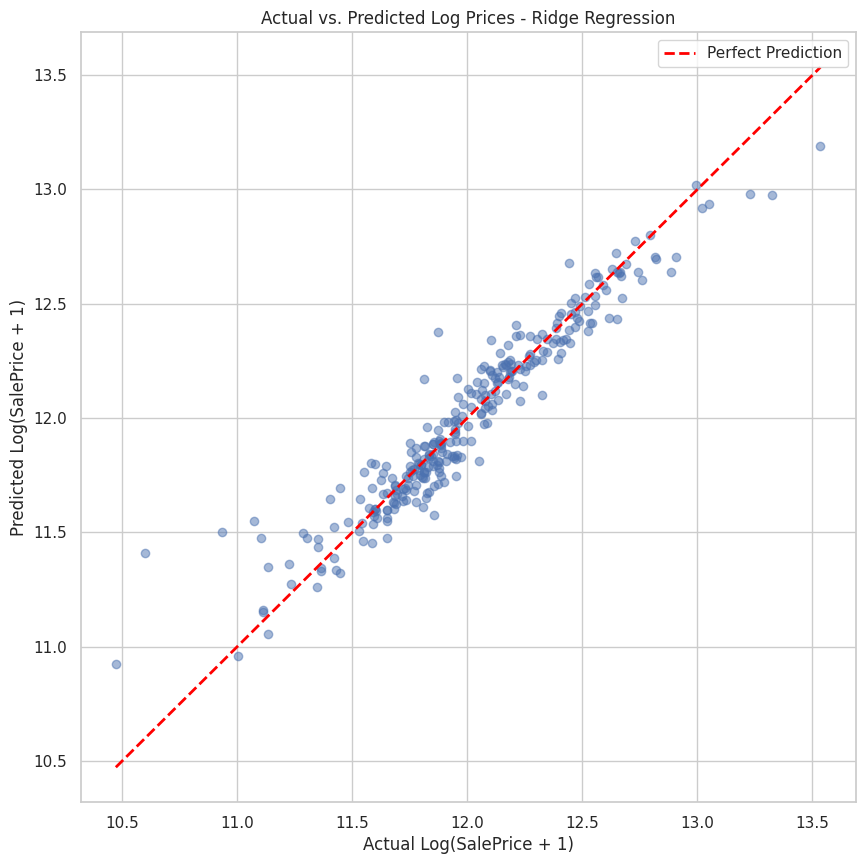

In [49]:
# Plot Actual vs Predicted for the best model (example: find best based on RMSE_log)
best_model_name = comparison_df.sort_values(by='RMSE (log scale)', ascending=True).iloc[0]['Model']
best_model_preds = results[best_model_name]['y_pred_log_val']

print(f"\n--- Plotting Actual vs Predicted for Best Model: {best_model_name} ---")

plt.figure(figsize=(10, 10))
plt.scatter(y_val, best_model_preds, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Log(SalePrice + 1)")
plt.ylabel("Predicted Log(SalePrice + 1)")
plt.title(f"Actual vs. Predicted Log Prices - {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion

This project involved predicting house prices using the Ames Housing dataset.

1.  **Data Exploration & Cleaning:** We analyzed the data, noting the skewed distribution of `SalePrice` which was addressed with a log transformation (`SalePrice_Log`). Extensive missing values were identified and handled strategically based on their likely meaning (e.g., NA means 'None' vs. NA needs imputation). Skewed numerical features were also log-transformed.
2.  **Preprocessing:** A comprehensive preprocessing pipeline was built using `ColumnTransformer` and `Pipeline` to handle missing value imputation (done mostly manually beforehand based on analysis), ordinal and nominal categorical encoding, numerical feature scaling, and log-transformation of skewed features.
3.  **Model Training & Evaluation:** Ridge Regression, Random Forest, and Gradient Boosting models were trained to predict the log-transformed sale price. Performance was evaluated primarily using RMSE on the log-transformed predictions on a validation set (a proxy for RMSLE).

**Findings:**
*   [Comment on model performance, e.g., "The Gradient Boosting Regressor achieved the lowest RMSE on the validation set, suggesting it captured the underlying patterns most effectively among the models tested."] *Refer to your specific output.*
*   The log transformation of the target variable and skewed features significantly helped in meeting the assumptions of linear models and stabilizing the variance for tree-based models.
*   Feature engineering and careful handling of missing data based on domain understanding (e.g., NA = 'None') are crucial for this dataset.

**Potential Future Work:**
*   **Hyperparameter Tuning:** Optimize the parameters of the best-performing models (e.g., Gradient Boosting, Random Forest) using techniques like GridSearchCV or RandomizedSearchCV with cross-validation, targeting the RMSLE metric.
*   **Advanced Feature Engineering:** Create interaction terms (e.g., `TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF`) or polynomial features. Bin numerical features like 'YearBuilt'.
*   **More Sophisticated Imputation:** Use model-based imputation (e.g., KNNImputer) or more targeted median/mode imputation (e.g., `LotFrontage` based on `Neighborhood`).
*   **Ensemble Methods/Stacking:** Combine predictions from multiple strong models to potentially improve robustness and accuracy.
*   **Outlier Handling:** Investigate and potentially handle outliers identified during EDA (e.g., extremely large `GrLivArea` houses with low prices).
*   **Full Competition Submission:** Use the trained model and preprocessor to predict prices on `test.csv` and format for submission to the Kaggle competition.
